### Assignment 4. Variable Elimination algorithm

In [7]:
import copy
import itertools
from IPython.display import Image

In [8]:
# Class to define Bayesian Network variables
class Variable:
    
    # create an instance by giving the name of the variable and the list of values
    # that variable could take
    
    def __init__(self, name, values=[]):
        self.name = name                
        self.values = list(values)        
        self.idx_evidence = 0         
        self.idx_assignment = 0
        
    def size(self):
        return len(self.values)
    
    def indexOf(self, val):
        return self.values.index(val)

    def set_evidence(self, evidenceValue):
        self.idx_evidence = self.values.index(evidenceValue)

    def get_evidence(self):
        return(self.values[self.idx_evidence])

    def set_assignment(self, val):
        self.idx_assignment = self.values.index(val)

    def get_assignment(self):
        return(self.values[self.idx_assignment])

    def set_assignment_index(self, index):
        self.idx_assignment = index

In [9]:
# Factor class provides methods to define a factor object, represented by a table of values
class Factor: 

    # On creation specify the name of the factor and its' scope (list of variables of the factor)
    def __init__(self, name, scope):
        
        self.name = name
        self.scope = list(scope)
        
        size = 1
        for variable in scope:
            size = size * len(variable.values)
        self.values = [0]*size  #initialize values to be long list of zeros.

    def get_scope(self):
        return list(self.scope)

    '''Parameter values is a list of lists [[..][..]...[..]], where each inner sublist is an ordered sequence of values.
    For example, let factor contains 2 variables X with X.values = [x1, x2] and Y with Y.values = [y1, y2].
    In order to set values to the factor, we pass the list of all possible combinations between
    X and Y values with the corresponding value assigned:
    [[x1, y1, 0.1],
    [x1, y2, 0.3],
    [x2, y1, 0.2],
    [x2, y2, 0.7]]
    '''
    def set_values(self, values):

        for assignment in values:
            # pointer to the value in assignment
            i = 0
            
            # index in factor list of values
            index = 0
            for variable in self.scope:
                val = assignment[i]
                index = index * variable.size() + variable.indexOf(val)
                i += 1
            
            # last value of the assignment list is factor's value
            self.values[index] = assignment[i]
         
    '''To run this method, the values of the factor variables should be assigned first. For example, X.set_assignment('x1');
    Y.set_assignment('y2').
    Then the call with parameter number = 0.7 would set the factor value for the assignment (X = 'x1', Y = 'y2')
    '''
    
    def set_value_at_current_assignment(self, number): 

        index = 0
        for variable in self.scope:
            index = index * variable.size() + variable.idx_assignment
        self.values[index] = number

    # get factor value for the particular assignment (variables_values)
    def get_value(self, variables_values):
        i = 0
        index = 0
        for variable in self.scope:
            val = variables_values[i]
            index = index * variable.size() + variable.indexOf(val)
            i += 1
        return self.values[index]

    # get factor value for the currently assigned values of the factor scope variables
    def get_value_at_current_assignments(self):
        
        index = 0
        for variable in self.scope:
            index = index * variable.size() + variable.idx_assignment
        return self.values[index]

In [10]:
# Class to buid Bayesian Network.
# Specify the name of the network, input the list of variables and list of factors.

class BayesianNetwork:

    def __init__(self, name, Variables, Factors):
        self.name = name
        self.Variables = list(Variables)
        self.Factors = list(Factors)
        self.validate_network()
        
    def validate_network(self):
        for f in self.Factors:
            for v in f.get_scope():     
                if not v in self.Variables:
                    print("Bayes net initialization error: factor scope has variable that BayesianNetwork does not contain")

### Task 1

Implement function to return a product of factors. 

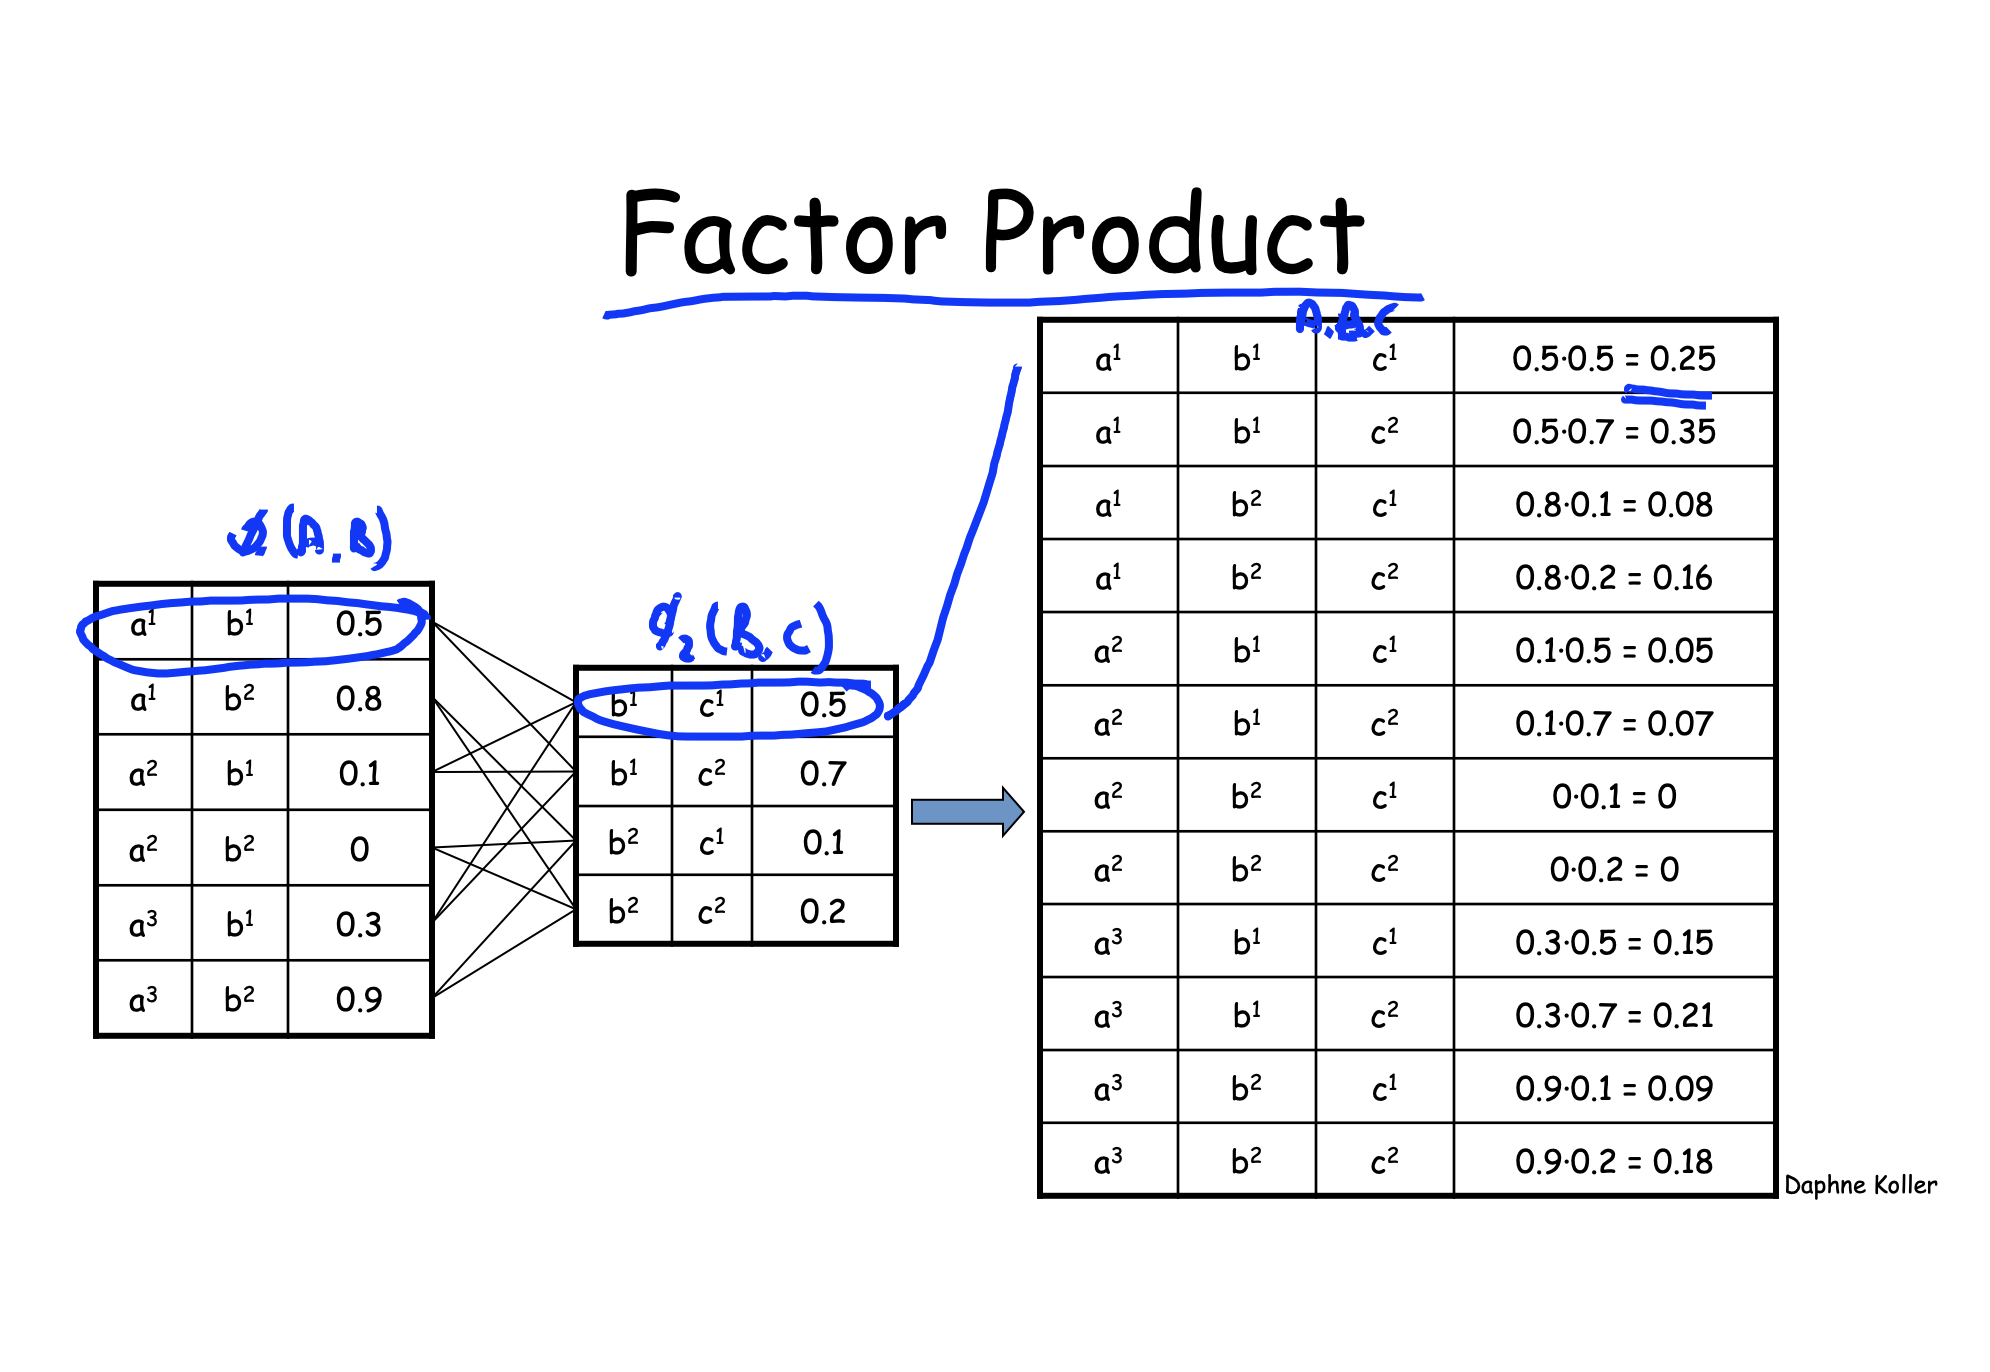

In [11]:
Image('/Users/Zarbali/Documents/Advanced_ML/Factor_product.png')

In [12]:
def union_vars(Factors):
    vars_set = set()
    for f in Factors:
        for v in f.get_scope():
            vars_set.add(v)
    return list(vars_set)

# Return a new factor that is the product of the factors in the list of Factors.
def multiply_factors(Factors):
    joined_variables = union_vars(Factors)
    product_factor = Factor("product_factor", joined_variables)
    joined_variable_values = [var.values for var in joined_variables]
    combinations = itertools.product(*joined_variable_values)
    combinations_list = list(combinations)

    for cur_comb in combinations_list:
        product = 1.0
        
        # assign values to the variables for the current combination
        for idx, value in enumerate(cur_comb):
            joined_variables[idx].set_assignment(value)
            
        for f in Factors:
            cur_value = f.get_value_at_current_assignments()
            product *= cur_value
        product_factor.set_value_at_current_assignment(product)

    return product_factor

### Task 2 

Implement reduction operation of the factor 

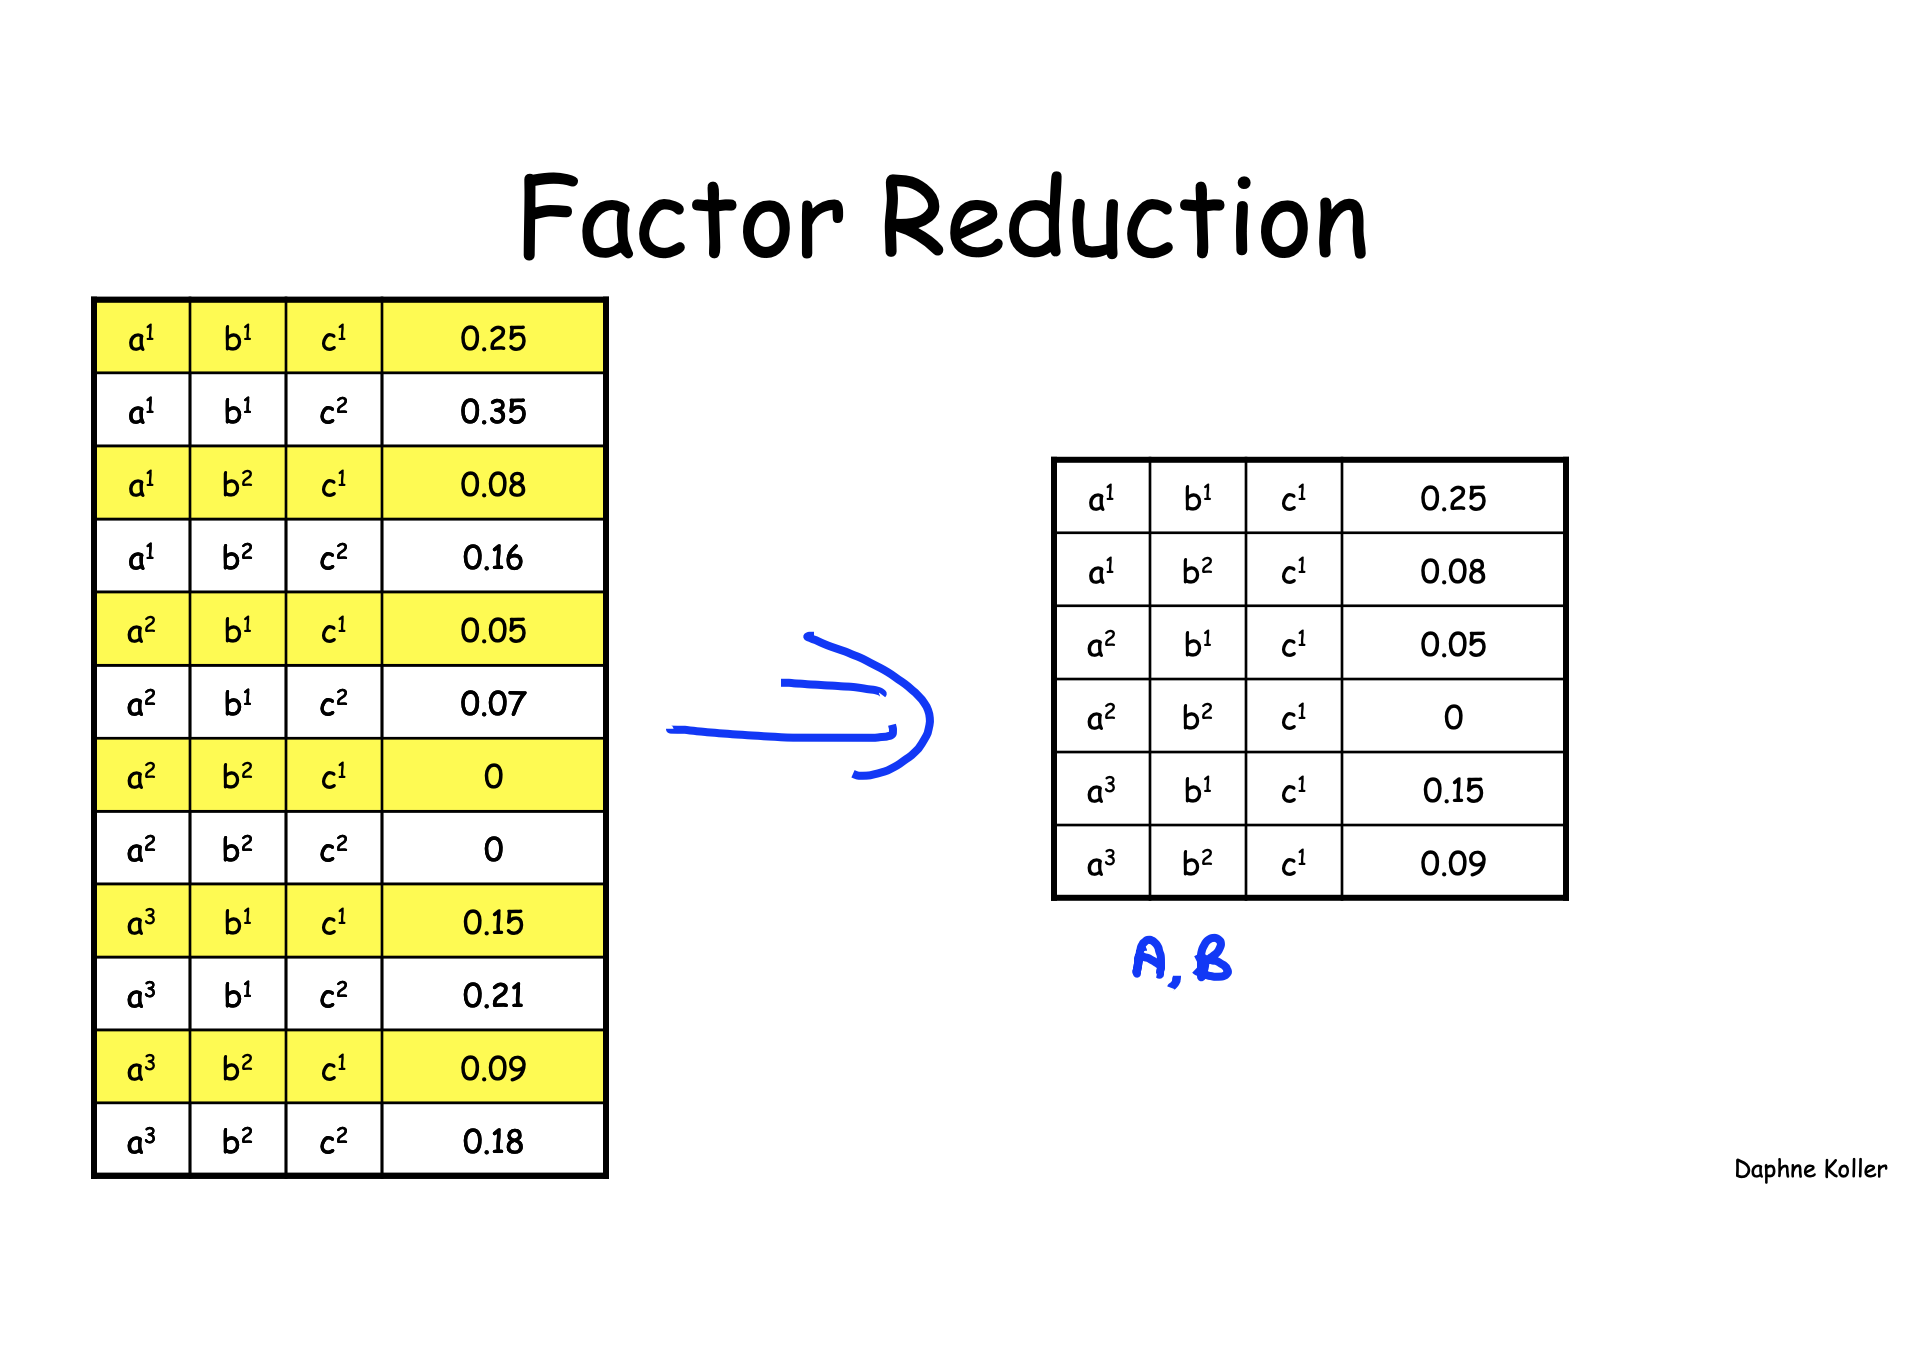

In [13]:
Image('/Users/Zarbali/Documents/Advanced_ML/Factor_restrict.png')

In [14]:
# f is a Factor, var is a Variable, and value is a value from the var.values.
# Return a new factor that is the reduction of f by variable var, set to value = value.
def reduce_factor(f, var, value):
    
    if var not in f.get_scope():
        new_factor = f
        return new_factor

    new_vars = f.get_scope()

    var_values = []
    v_index = 0
    for i, vl in enumerate(f.get_scope()):
        if vl == var:
            var_values.append([value])
            v_index += i
        else:
            var_values.append(vl.values)
    
    all_comb = itertools.product(*var_values) 
    list_all_comb = list(all_comb)
    new_vars.pop(v_index)
    new_factor = Factor("r-{}".format(f.name), new_vars)

    for comb in list_all_comb:
        comb_list = list(comb)
        new_prob = f.get_value(comb_list)
        comb_list.pop(v_index)
        comb_list.append(new_prob)
        new_factor.set_values([comb_list])
    return new_factor

### Task 3

Implement summing out operation to remove variable from the factor scope. For the example on the picture below, the new factor should contains only variables A and B in the scope. 

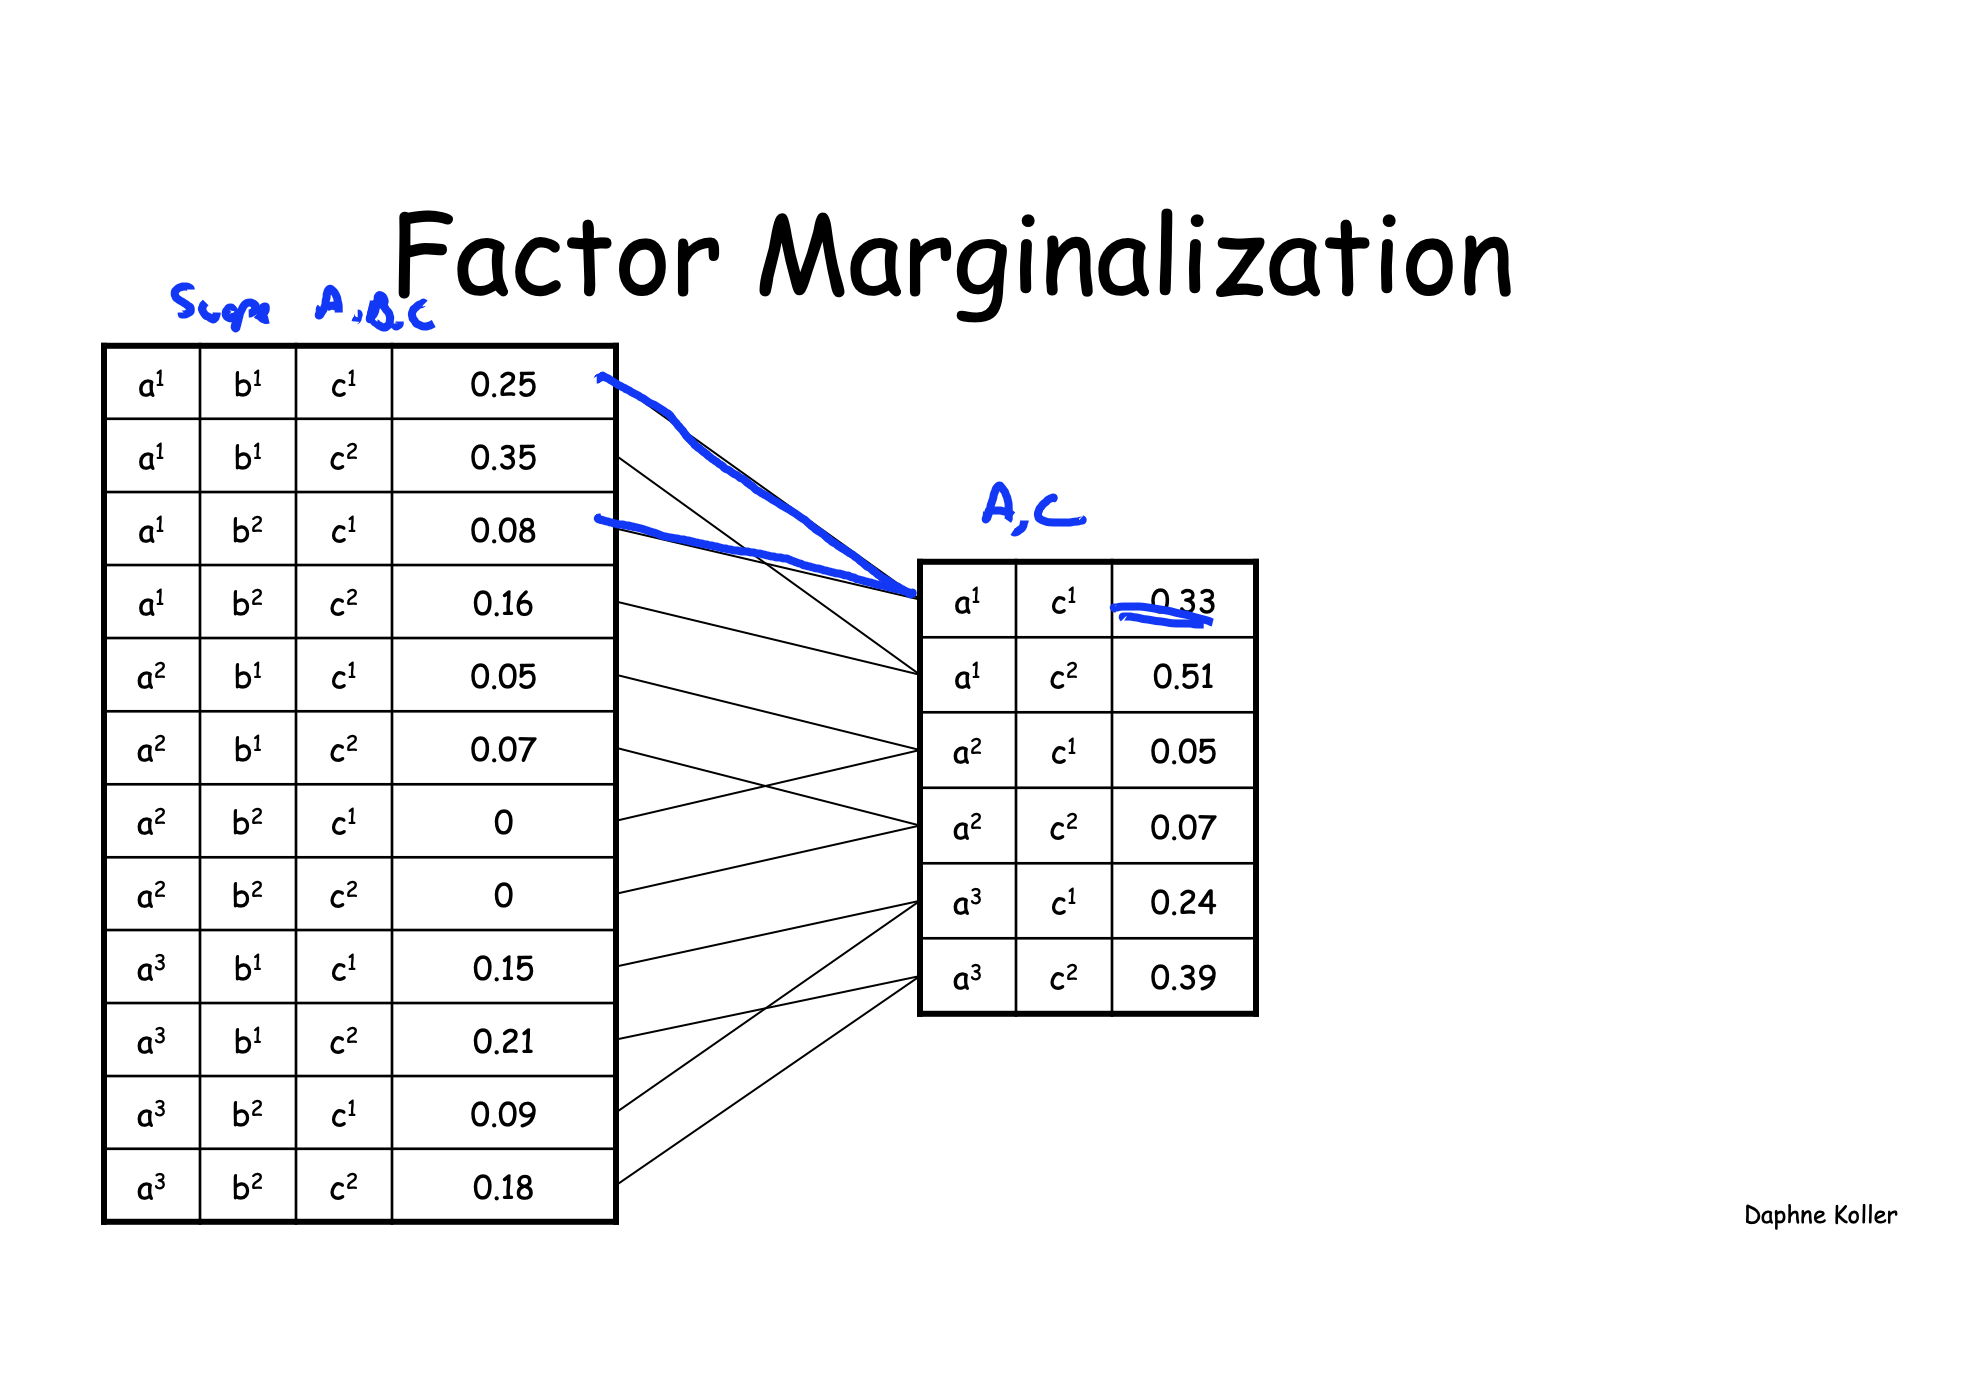

In [15]:
Image('/Users/Zarbali/Documents/Advanced_ML/Factor_sum_out.png')

In [16]:
# Return a new factor where Var was summed out
def sum_out_variable(f, var):
    new_vars = f.get_scope()
    
    # Remove variable that has to be summed out from the scope of the new factor
    for i, v in enumerate(f.get_scope()):
        if v == var:
            new_vars.pop(i)

    new_factor = Factor("s-{},{}".format(f.name, var.name), new_vars)

    var_values = [v.values for v in new_vars]
    all_comb = itertools.product(*var_values)
    list_all_comb = list(all_comb)

    for cur_comb in list_all_comb:
        sum_tot = 0
        for var_val in var.values:
            for j, val in enumerate(cur_comb):
                new_vars[j].set_assignment(val)
            var.set_assignment(var_val)
            cur_value = f.get_value_at_current_assignments()
            sum_tot += cur_value
        new_factor.set_value_at_current_assignment(sum_tot)

    return new_factor

### Task 4

Implement function that for the input list of factors and query variable returns the MinFill ordering of the variables to eliminate.

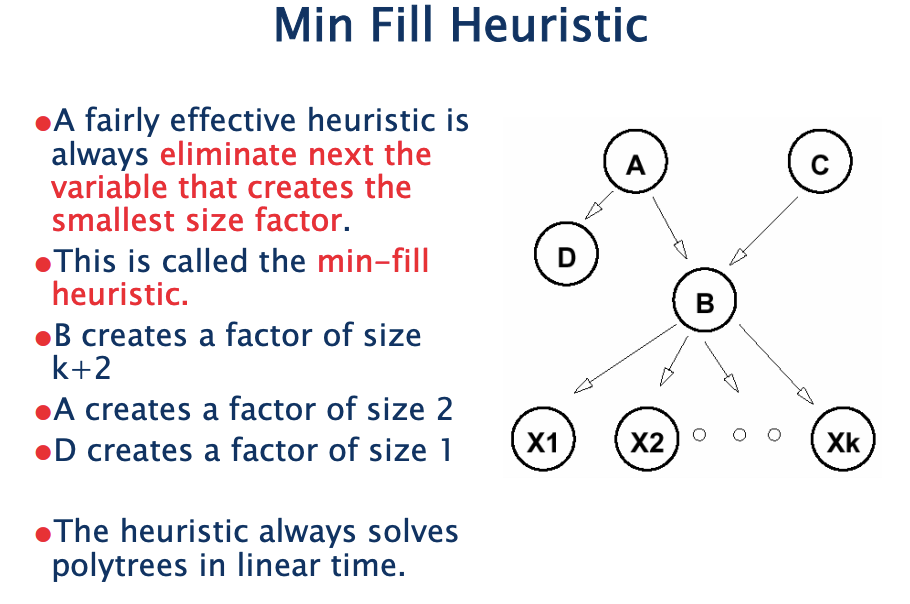

In [17]:
Image('/Users/Zarbali/Documents/Advanced_ML/Min_Fill_Heuristic.png')

In [18]:
def min_fill_ordering(Factors, QueryVar):

    scopes = []
    for f in Factors:
        scopes.append(list(f.get_scope()))
    
    # populate the joined list of variablies from all factors, except QueryVar
    variables = []
    for s in scopes:
        for v in s:
            if not v in variables and v != QueryVar:
                variables.append(v)
    
    ordering = []
    while variables:
        # find variable var that will create the new factor with smallest scope new_scope
        (var, new_scope) = min_fill_var(scopes, variables)
        ordering.append(var)
        if var in variables:
            variables.remove(var)
            
        # remove this variable from the joined scope, add the scope of the new factor
        scopes = remove_var(var, new_scope, scopes)
        
        # continue the loop for the remaining variables and updated scopes without variable var
    return ordering

def min_fill_var(scopes, variables):

    min_variable = variables[0]
    (min_fill, min_new_scope) = compute_fill(scopes, min_variable)
    for v in variables[1:]:
        (fill, new_scope) = compute_fill(scopes, v)
        if fill < min_fill:
            min_variable = v
            min_fill = fill
            min_new_scope = new_scope
    return (min_variable, min_new_scope)

def compute_fill(scopes, var):

    # find all variables from the scopes, that contain var
    union_variables = set()
    for s in scopes:
        if var in s:
            for v in s:
                union_variables.add(v)
                    
    union_variables.remove(var)
    return (len(union_variables), union_variables)

def remove_var(var, new_scope, scopes):
    
    # join all scopes that do not contain variable var
    new_scopes = []
    for s in scopes:
        if not var in s:
            new_scopes.append(s)
            
    # add the new_scope after eliminating variable
    new_scopes.append(new_scope)
    return new_scopes

# Return all factors that contain variable var in the scope
def get_factors_over_variable(all_factors, var):
    f_over_var = []
    for f in all_factors:
        if var in f.get_scope():
            f_over_var.append(f)
    return f_over_var

### Task 5

Implement variable elimination algorithm, that calculates P(QueryVar | EvidenceVariables), given that evidence variables are assigned particular values.

In [58]:
"""
BayesianNetwork is an instance of the BayesianNetwork class.
QueryVar is the name of 1 variable of the inference, list is not accepted! 
EvidenceVariables is a list of variables, for which evidence values were assigned. 
In other words, you should first assign evidence values for the list of EvidenceVariables, then call the method.
Return probability distribution of the QueryVar - probability for each value of QueryVar, that should sum up to 1.
""" 
def VariableEliminationInference(BayesianNetwork, QueryVar, EvidenceVariables):

    bn_factors = []

    # Step 1. Reduce all factors by the values of the evidence variables
    for factor in BayesianNetwork.Factors:
        for e in EvidenceVariables:
            if e in factor.get_scope():
                factor = reduce_factor(factor, e, e.get_evidence())
        bn_factors.append(factor)

    # Step 2. Define the ordering of the network variables, except QueryVar and EvidenceVariables (because they have already been reduced)
    ordering = min_fill_ordering(bn_factors, QueryVar)
    
    print('MinFill ordering ')
    i = 1
    for var in ordering:
        print('{}) {}'.format(i, var.name))
        i += 1
    
    for var in ordering:
        
        # Step 3. Sum out variable from the product of factors over variable, following the MinFill order
        factors_over_variable = get_factors_over_variable(bn_factors, var)
        for f in factors_over_variable:
            bn_factors.remove(f)
        product_factor = multiply_factors(factors_over_variable)
        bn_factors.append(sum_out_variable(product_factor, var))
    
    # Step 4. Multiply all factors, resulting in 1 factor, containing values only for query variable
    query_factor = multiply_factors(bn_factors)
    
    queryVar_values = QueryVar.values
    queryVar_distribution = {}
    prob_sum = 0
    for idx, value in enumerate(queryVar_values):
        prob = query_factor.get_value([value])
        queryVar_distribution[value] = prob
        prob_sum += prob
    
    # Step 5. Normalize probability distribution
    normalized_probabilities = {}
    for value, prob in queryVar_distribution.items():
        normalized_probabilities[value] = prob / prob_sum

    return normalized_probabilities

### Task 6

1) Create an instance of the BayesianNetwork class from the Assignment 2, according to the conditional probability tables, provided on the picture below. Run variable elimination function to calculate the following probabilities:
P(Success|Experience = "5-10"), 
P(Prototype|Education="Business",Projects="Yes"), 
P(Success|Education="Technical",Productivity="Moderate"). 

2) Build the same Bayesian network with pgmpy package, run inference for the mentioned queries and compare results.

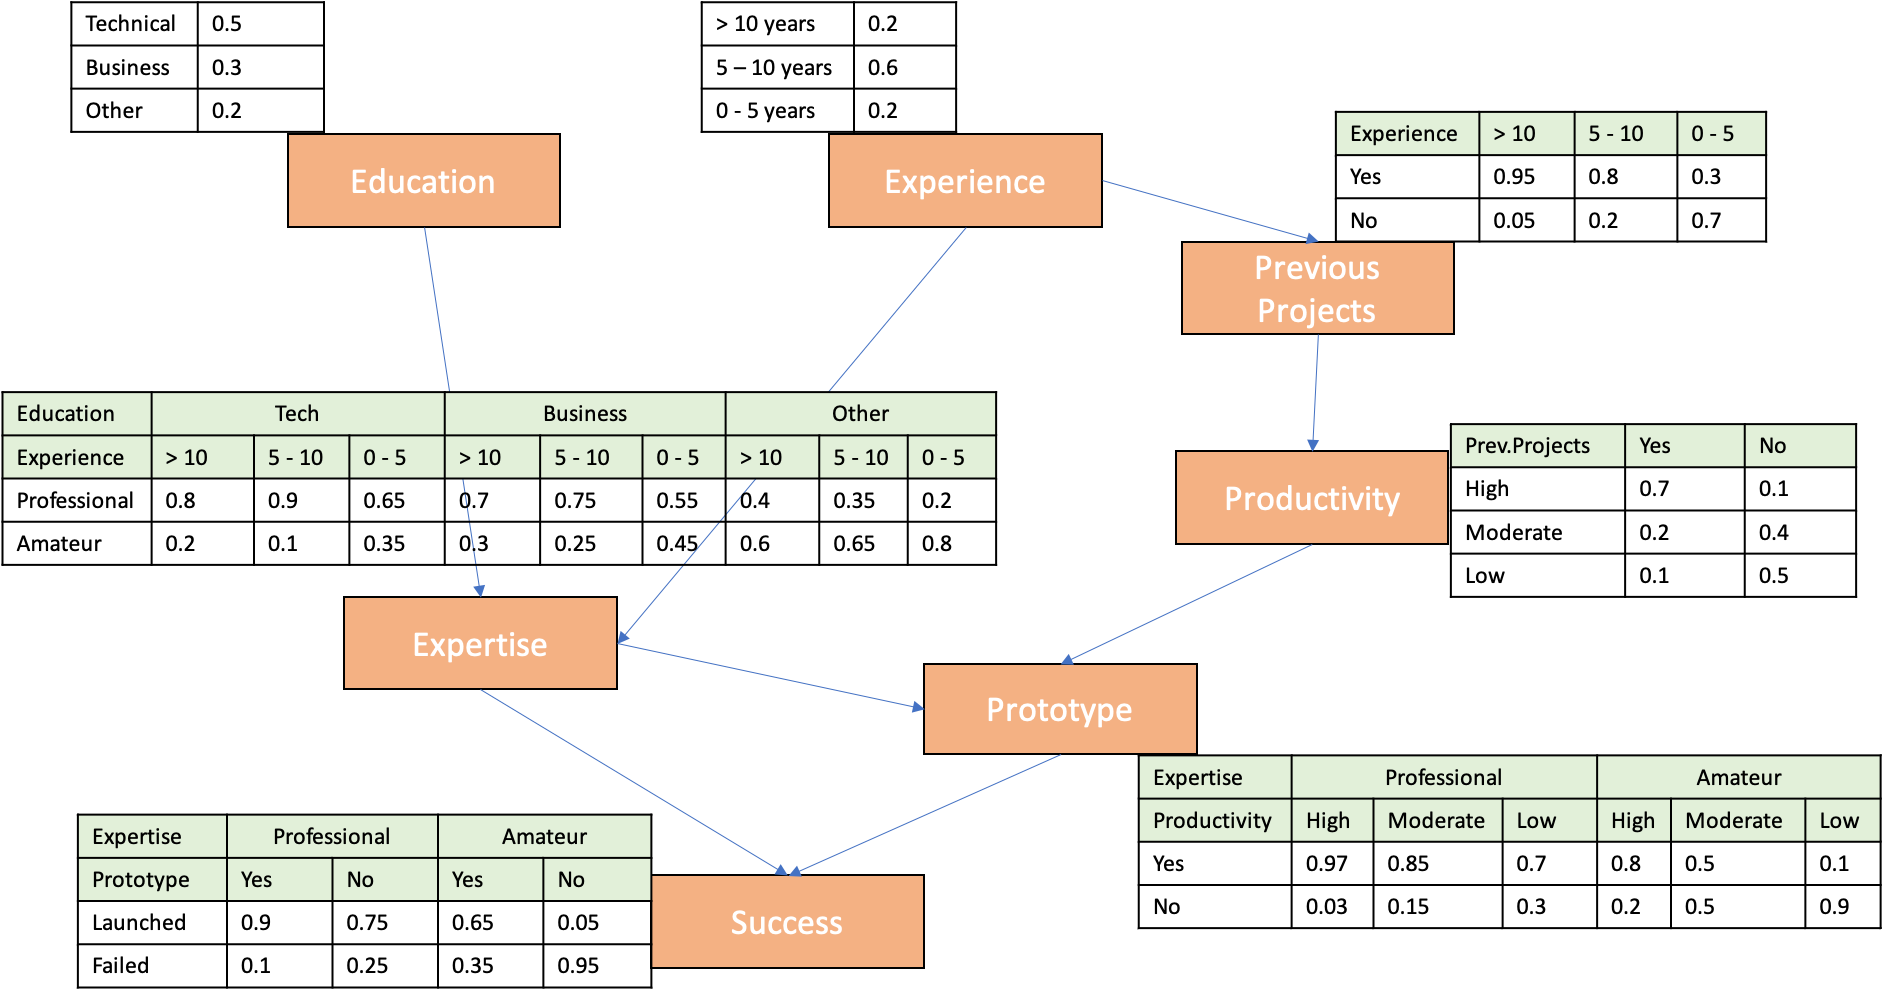

In [20]:
Image('/Users/Zarbali/Documents/Advanced_ML/Startup_model.png')

In [21]:
education = Variable('Education', ['Technical','Business', 'Other'])
experience = Variable('Experience', ['>10','5-10', '0-5'])
projects = Variable('Projects', ['Yes','No'])
productivity = Variable('Productivity', ['High','Moderate', 'Low'])
prototype = Variable('Prototype', ['Yes','No'])
expertise = Variable('Expertise', ['Professional','Amateur'])
success = Variable('Success', ['Launched','Failed'])

F_education = Factor("P(Education)", [education])
F_experience = Factor("P(Experience)", [experience])
F_projects = Factor("P(Projects|Experience)", [projects, experience])
F_productivity = Factor("P(Productivity|Projects)", [productivity, projects])
F_prototype = Factor("P(Prototype|Expertise, Productivity)", [prototype, expertise, productivity])
F_expertise = Factor("P(Expertise|Education, Experience)", [expertise, education, experience])
F_success = Factor("P(Success|Expertise, Prototype)", [success, expertise, prototype])

In [22]:
F_education.set_values([
    ['Technical', 0.5], 
    ['Business', 0.3],
    ['Other', 0.2]])
F_experience.set_values([
    ['>10', 0.2], 
    ['5-10', 0.6],
    ['0-5', 0.2]])
F_projects.set_values([
    ['Yes','>10',0.95],
    ['Yes','5-10',0.8],
    ['Yes','0-5',0.3],
    ['No','>10',0.05],
    ['No','5-10',0.2],
    ['No','0-5',0.7]])
F_productivity.set_values([
    ['High','Yes',0.7],
    ['High','No',0.1],
    ['Moderate','Yes',0.2],
    ['Moderate','No',0.4],
    ['Low','Yes',0.1],
    ['Low','No',0.5]])
F_prototype.set_values([
    ['Yes', 'Professional', 'High', 0.97], 
    ['Yes', 'Professional', 'Moderate', 0.85], 
    ['Yes', 'Professional', 'Low', 0.7], 
    ['Yes', 'Amateur', 'High', 0.8], 
    ['Yes', 'Amateur', 'Moderate', 0.5], 
    ['Yes', 'Amateur', 'Low', 0.1], 
    ['No', 'Professional', 'High', 0.03], 
    ['No', 'Professional', 'Moderate', 0.15], 
    ['No', 'Professional', 'Low', 0.3], 
    ['No', 'Amateur', 'High', 0.2], 
    ['No', 'Amateur', 'Moderate', 0.5], 
    ['No', 'Amateur', 'Low', 0.9]])
F_expertise.set_values([
    ['Professional', 'Technical', '>10', 0.8], 
    ['Professional', 'Technical', '5-10', 0.9], 
    ['Professional', 'Technical', '0-5', 0.65], 
    ['Professional', 'Business', '>10', 0.7], 
    ['Professional', 'Business', '5-10', 0.75], 
    ['Professional', 'Business', '0-5', 0.55], 
    ['Professional', 'Other', '>10', 0.4], 
    ['Professional', 'Other', '5-10', 0.35], 
    ['Professional', 'Other', '0-5', 0.2], 
    ['Amateur', 'Technical', '>10', 0.2], 
    ['Amateur', 'Technical', '5-10', 0.1], 
    ['Amateur', 'Technical', '0-5', 0.35], 
    ['Amateur', 'Business', '>10', 0.3], 
    ['Amateur', 'Business', '5-10', 0.25], 
    ['Amateur', 'Business', '0-5', 0.45], 
    ['Amateur', 'Other', '>10', 0.6], 
    ['Amateur', 'Other', '5-10', 0.65], 
    ['Amateur', 'Other', '0-5', 0.8]])
F_success.set_values([
    ['Launched', 'Professional', 'Yes', 0.9], 
    ['Launched', 'Professional', 'No', 0.75], 
    ['Launched', 'Amateur', 'Yes', 0.65], 
    ['Launched', 'Amateur', 'No', 0.05], 
    ['Failed', 'Professional', 'Yes', 0.1], 
    ['Failed', 'Professional', 'No', 0.25],
    ['Failed', 'Amateur', 'Yes', 0.35],  
    ['Failed', 'Amateur', 'No', 0.95]])


In [23]:
success_network = BayesianNetwork('success', 
                                  [education, experience, projects, productivity, prototype, expertise, success], 
                                  [F_education,F_experience,F_projects,F_productivity,F_prototype,F_expertise,F_success])


In [59]:
experience.set_evidence('5-10')
probabilities = VariableEliminationInference(success_network, success, [experience])
print("P(Success = Launched | Experience = '5-10') = {0:0.2f}".format(probabilities['Launched']))
print("P(Success = Failed | Experience = '5-10') = {0:0.2f}".format(probabilities['Failed']))

MinFill ordering 
1) Education
2) Projects
3) Productivity
4) Prototype
5) Expertise
P(Success = Launched | Experience = '5-10') = 0.76
P(Success = Failed | Experience = '5-10') = 0.24


In [60]:
education.set_evidence('Business')
projects.set_evidence('Yes')
probabilities = VariableEliminationInference(success_network, prototype, [education, projects])
print("P(Prototype = Yes | Education = 'Business', Projects = 'Yes') = {0:0.2f}".format(probabilities['Yes']))
print("P(Prototype = No | Education = 'Business', Projects = 'Yes') = {0:0.2f}".format(probabilities['No']))

MinFill ordering 
1) Experience
2) Productivity
3) Expertise
4) Success
P(Prototype = Yes | Education = 'Business', Projects = 'Yes') = 0.85
P(Prototype = No | Education = 'Business', Projects = 'Yes') = 0.15


In [62]:
education.set_evidence('Technical')
productivity.set_evidence('Moderate')
probabilities = VariableEliminationInference(success_network, success, [education, productivity])
print("P(Success = Launched | Productivity = 'Moderate', Education = 'Technical') = {0:0.2f}".format(probabilities['Launched']))
print("P(Success = Failed | Productivity = 'Moderate', Education = 'Technical') = {0:0.2f}".format(probabilities['Failed']))

MinFill ordering 
1) Projects
2) Experience
3) Prototype
4) Expertise
P(Success = Launched | Productivity = 'Moderate', Education = 'Technical') = 0.78
P(Success = Failed | Productivity = 'Moderate', Education = 'Technical') = 0.22


In [27]:
from pgmpy.factors.discrete import TabularCPD
from pgmpy.models import BayesianModel
from pgmpy.inference import VariableElimination
import numpy as np
import pandas as pd

In [28]:
startup_model = BayesianModel([('Education', 'Expertise'),
                               ('Experience', 'Expertise'),
                               ('Experience','Projects'),
                               ('Expertise','Prototype'),
                               ('Expertise', 'Success'),
                               ('Projects','Productivity'),
                               ('Productivity','Prototype'),
                               ('Prototype','Success')])

cpd_education = TabularCPD(variable='Education', 
                      variable_card=3,
                      values=[[0.5],[0.3],[0.2]])

cpd_experience = TabularCPD(variable='Experience', 
                      variable_card=3,
                      values=[[0.2],[0.6],[0.2]])

cpd_expertise = TabularCPD(variable='Expertise', 
                      variable_card=2,
                      values=[[0.8,0.9,0.65,0.7,0.75,0.55,0.4,0.35,0.2], [0.2,0.1,0.35,0.3,0.25,0.45,0.6,0.65,0.8]], 
                      evidence=['Education','Experience'], 
                      evidence_card=[3, 3])

cpd_projects = TabularCPD(variable='Projects', 
                      variable_card=2,
                      values=[[0.95,0.8,0.3], [0.05,0.2,0.7]], 
                      evidence=['Experience'], 
                      evidence_card=[3])

cpd_productivity = TabularCPD(variable='Productivity', 
                      variable_card=3,
                      values=[[0.7,0.1],[0.2,0.4],[0.1,0.5]], 
                      evidence=['Projects'], 
                      evidence_card=[2])

cpd_prototype = TabularCPD(variable='Prototype', 
                      variable_card=2,
                      values=[[0.97,0.85,0.7,0.8,0.5,0.1], [0.03,0.15,0.3,0.2,0.5,0.9]], 
                      evidence=['Expertise','Productivity'], 
                      evidence_card=[2, 3])

cpd_success = TabularCPD(variable='Success', 
                      variable_card=2,
                      values=[[0.9,0.75,0.65,0.05], [0.1,0.25,0.35,0.95]], 
                      evidence=['Expertise','Prototype'], 
                      evidence_card=[2, 2])

# Associating the parameters with the model structure.
startup_model.add_cpds(cpd_education, cpd_experience, cpd_expertise, cpd_projects, cpd_productivity, cpd_prototype, cpd_success)
startup_model.check_model()

True

In [29]:
inference = VariableElimination(startup_model)
query = inference.query(['Success'], evidence = {'Experience':1})
print(query)

Eliminating: Productivity: 100%|██████████| 5/5 [00:00<00:00, 641.68it/s]

+------------+----------------+
| Success    |   phi(Success) |
+============+================+
| Success(0) |         0.7634 |
+------------+----------------+
| Success(1) |         0.2366 |
+------------+----------------+


In [30]:
query = inference.query(['Prototype'], evidence = {'Education':1, 'Projects':0})
print(query)

Eliminating: Productivity: 100%|██████████| 4/4 [00:00<00:00, 673.76it/s]

+--------------+------------------+
| Prototype    |   phi(Prototype) |
+==============+==================+
| Prototype(0) |           0.8494 |
+--------------+------------------+
| Prototype(1) |           0.1506 |
+--------------+------------------+


In [31]:
query = inference.query(['Success'], evidence = {'Education':0, 'Productivity':1})
print(query)

Eliminating: Projects: 100%|██████████| 4/4 [00:00<00:00, 750.62it/s]

+------------+----------------+
| Success    |   phi(Success) |
+============+================+
| Success(0) |         0.7807 |
+------------+----------------+
| Success(1) |         0.2193 |
+------------+----------------+
